<a href="https://colab.research.google.com/github/Nischalj10/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

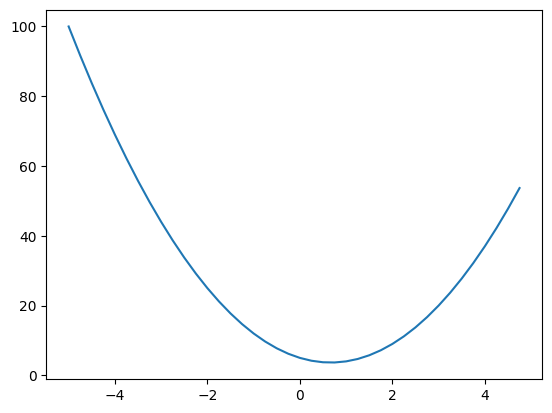

In [10]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [17]:
h = 0.000000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [18]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [21]:
h = 0.00001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h

d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)



d1 4.0
d2 4.00001
slope 0.9999999999621422


In [32]:
import math
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += (other * (self.data ** (other-1))) * out.grad

    out._backward = _backward

    return out

  def __rmul__(self, other): #other * self (eg 2 * a)
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self): #-self
    return self * -1

  def __sub__(self, other): #self - other
    return self + (-other)



  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [186]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [44]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [187]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n=x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

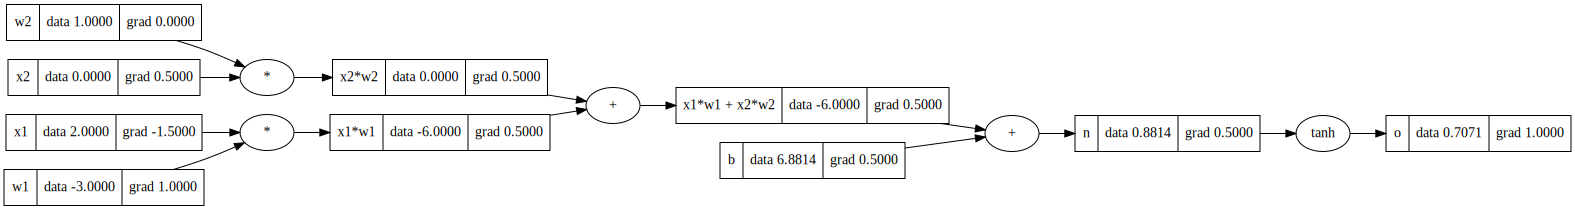

In [188]:
o.backward( )
draw_dot(o)

In [202]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n=x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)

o.label='o'

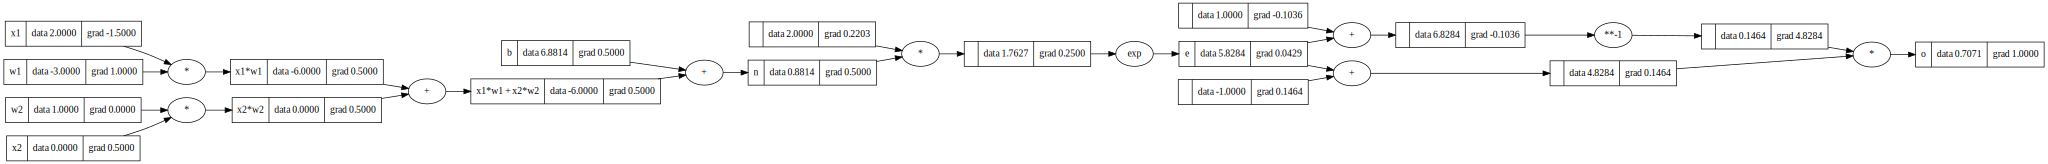

In [203]:
o.backward( )
draw_dot(o)

In [216]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad =True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [99]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    activation = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)
    return(params)



x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9327264855878814)

In [100]:
n.parameters()

[Value(data=0.25001137494484005),
 Value(data=-0.5952205741471679),
 Value(data=-0.4036110573778302),
 Value(data=-0.7999053179867446),
 Value(data=0.5947077329502908),
 Value(data=0.39726218741768315),
 Value(data=-0.339707260812558),
 Value(data=-0.7266863316062124),
 Value(data=-0.8843623973644399),
 Value(data=0.15525773660488196),
 Value(data=0.7100583797139495),
 Value(data=0.15248433111209692),
 Value(data=0.07319404321253953),
 Value(data=0.3602644522063849),
 Value(data=0.9688198865300945),
 Value(data=-0.43238816510647005),
 Value(data=0.8959311233066765),
 Value(data=-0.072861513770615),
 Value(data=0.11271192532138596),
 Value(data=-0.5016104282506657),
 Value(data=-0.2825376598732756),
 Value(data=-0.09939878510271849),
 Value(data=0.11817494178203014),
 Value(data=-0.937032541523706),
 Value(data=0.94244201754348),
 Value(data=0.6290199293653453),
 Value(data=-0.6757696259350334),
 Value(data=0.6501874697662553),
 Value(data=-0.7552319432283336),
 Value(data=-0.2177275539

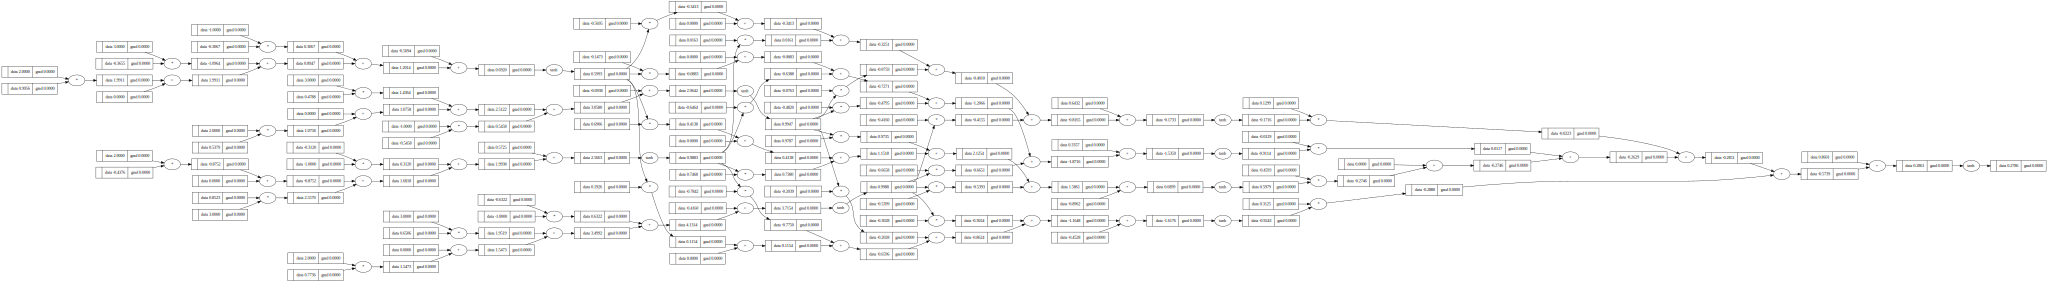

In [45]:
draw_dot(n(x))

In [101]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired tragets

In [104]:
for k in range(30):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
  print(loss)

  #backward pass
  loss.backward()

  #update params
  for p in n.parameters():
    p.data += -0.01 * p.grad

ypred

Value(data=3.014818009594064e-08)
Value(data=1.8078479244584445e-08)
Value(data=1.0890382208927446e-08)
Value(data=6.5925897562880655e-09)
Value(data=4.011974266891014e-09)
Value(data=2.4553555007814784e-09)
Value(data=1.5118130877588431e-09)
Value(data=9.368957377978837e-10)
Value(data=5.846344330878141e-10)
Value(data=3.6751590921496307e-10)
Value(data=2.3284806124066496e-10)
Value(data=1.4876009506731999e-10)
Value(data=9.5881671471581e-11)
Value(data=6.23795389736837e-11)
Value(data=4.0985564766122266e-11)
Value(data=2.7209958513795234e-11)
Value(data=1.8262435475429444e-11)
Value(data=1.2397872076259944e-11)
Value(data=8.517528624754865e-12)
Value(data=5.9247968704867376e-12)
Value(data=4.1748010809968415e-12)
Value(data=2.981274009474508e-12)
Value(data=2.158560162939329e-12)
Value(data=1.5852760239371515e-12)
Value(data=1.1813956949954754e-12)
Value(data=8.937068550189964e-13)
Value(data=6.865164803781791e-13)
Value(data=5.356695815150254e-13)
Value(data=4.246721375914524e-13)
V

[Value(data=0.9999995847301802),
 Value(data=-0.9999999999999999),
 Value(data=-0.9999999999999999),
 Value(data=0.9999995880408818)]

In [98]:
ypred

[Value(data=0.914905616840596),
 Value(data=-0.9852895255272587),
 Value(data=-0.9837704657464584),
 Value(data=0.9125636323743408)]

In [95]:
loss.backward()

In [64]:
n.layers[0].neurons[0].w[0].grad

0.0786153514399228

In [69]:
n.layers[0].neurons[0].w[0].data

-0.8268093102716908

In [96]:
for p in n.parameters():
  p.data += -0.01 * p.grad

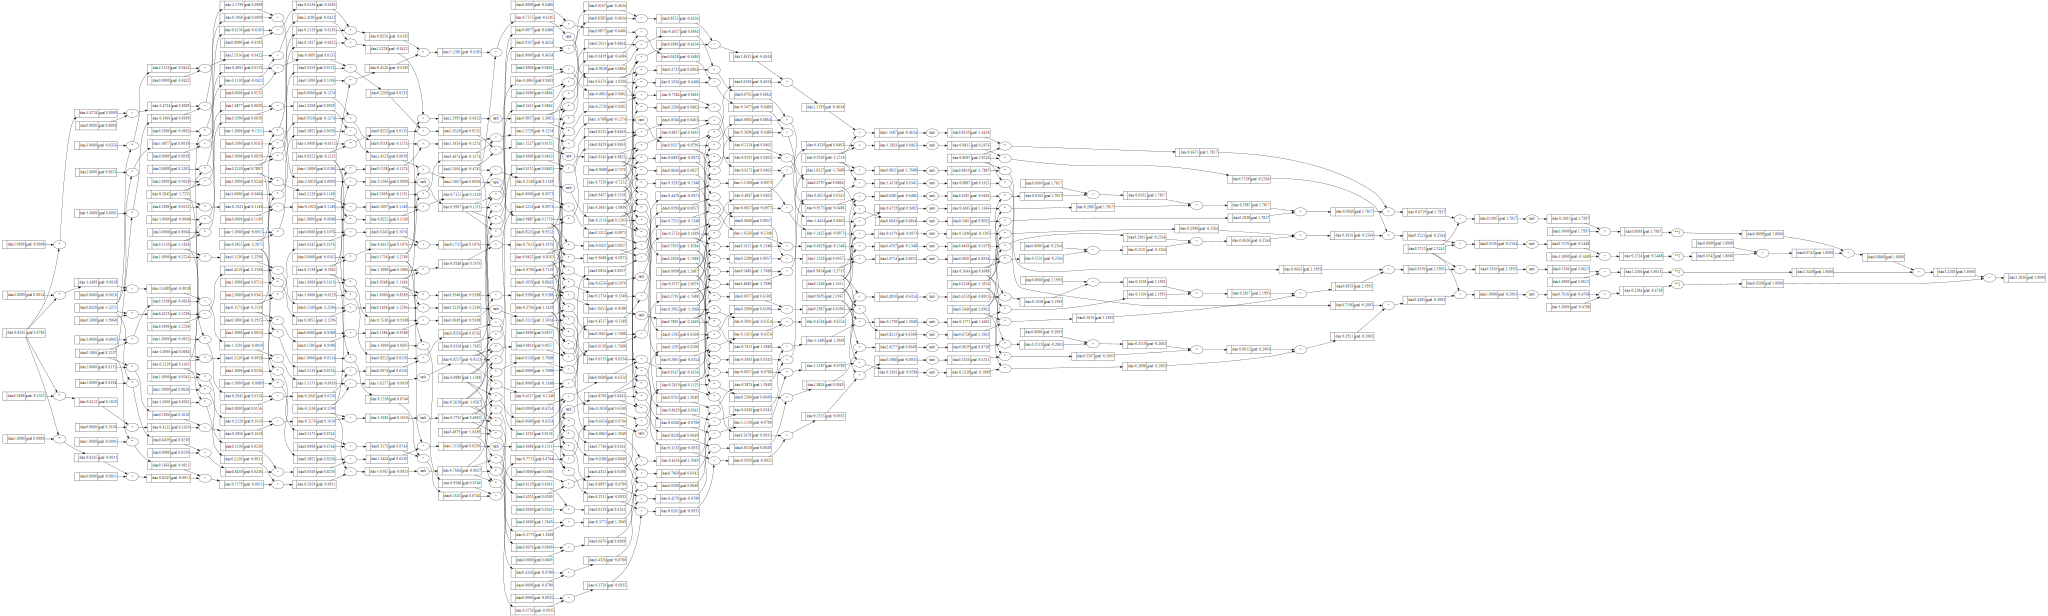

In [62]:
draw_dot(loss)